In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from scipy.stats import chisquare, chi2_contingency


In [4]:
data = pd.read_csv('secondary_data.csv', sep=';')


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [5]:
print(data.isnull().sum())

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64


In [6]:
data_without_missing_values=data.drop(columns=['cap-surface','gill-spacing','stem-root','stem-surface','veil-type','veil-color','spore-print-color'])

data_without_missing_values['gill-attachment'] = data_without_missing_values['gill-attachment'].fillna('u')
data_without_missing_values['ring-type'] = data_without_missing_values['ring-type'].fillna('u')

In [7]:
print(data_without_missing_values.describe(include='all'))

        class  cap-diameter cap-shape cap-color does-bruise-or-bleed  \
count   61069  61069.000000     61069     61069                61069   
unique      2           NaN         7        12                    2   
top         p           NaN         x         n                    f   
freq    33888           NaN     26934     24218                50479   
mean      NaN      6.733854       NaN       NaN                  NaN   
std       NaN      5.264845       NaN       NaN                  NaN   
min       NaN      0.380000       NaN       NaN                  NaN   
25%       NaN      3.480000       NaN       NaN                  NaN   
50%       NaN      5.860000       NaN       NaN                  NaN   
75%       NaN      8.540000       NaN       NaN                  NaN   
max       NaN     62.340000       NaN       NaN                  NaN   

       gill-attachment gill-color   stem-height    stem-width stem-color  \
count            61069      61069  61069.000000  61069.0000

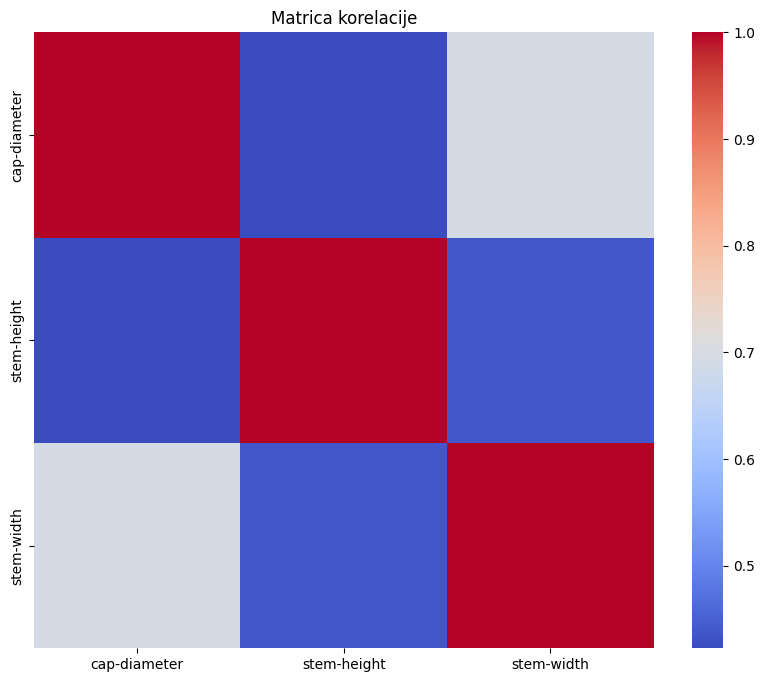

In [8]:
# Korelacijska matrica
corr_matrix = data_without_missing_values.select_dtypes(['number']).corr()

# Heatmap radi preglednosti
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Matrica korelacije")
plt.show()

In [9]:
def cramers_v(conf_matrix):
    """
    Cramer's V measure for association between two categorical variables.
    """
    n = conf_matrix.sum().sum()
    r, k = conf_matrix.shape
    return np.sqrt((chi2_contingency(conf_matrix)[0] / n) / (min(r-1, k-1)))

In [10]:
# List svih categorical varijabli
categorical = data_without_missing_values.select_dtypes(['object']).columns

# Pair-wise Cramer's V
cramer_matrix = pd.DataFrame(np.ones((len(categorical), len(categorical))),
                             index=categorical,
                             columns=categorical)

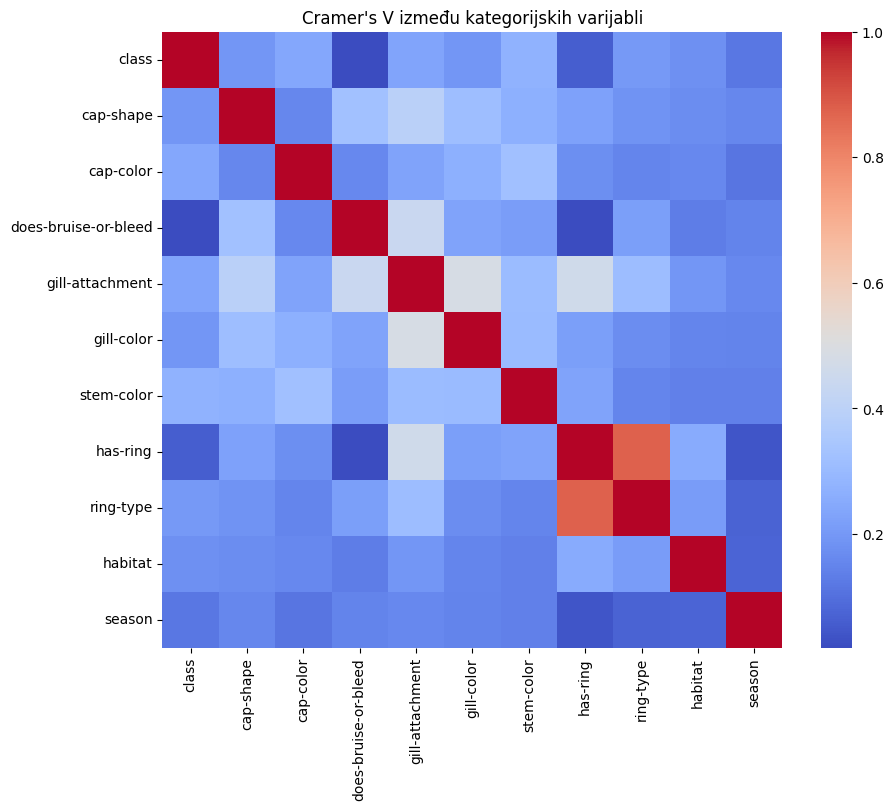

In [11]:
for i in range(len(categorical)):
    for j in range(i+1, len(categorical)):
        var1 = categorical[i]
        var2 = categorical[j]
        table = pd.crosstab(data[var1], data[var2])
        cramer_v = cramers_v(table)
        cramer_matrix.iloc[i, j] = cramer_v
        cramer_matrix.iloc[j, i] = cramer_v

# Heatmap Cramer's V
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, cmap='coolwarm', annot=False)
plt.title("Cramer's V između kategorijskih varijabli")
plt.show()

In [12]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

In [15]:
import mlflow
import mlflow.sklearn
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# transformacija podataka
X = pd.get_dummies(data.drop("class", axis=1))
y = data["class"].map({'e': 0, 'p': 1})

In [17]:
# Definiranje modela i parametara
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "kNN": KNeighborsClassifier(),
    "SVC": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

In [18]:
param_grid = {
    "Decision Tree": [{"max_depth": d} for d in [3, 5, 10]],
    "Random Forest": [{"n_estimators": n, "max_depth": d} for n in [50, 100] for d in [5, 10]],
    "kNN": [{"n_neighbors": k} for k in [3, 5, 7]],
    "SVC": [{"C": c, "kernel": "rbf"} for c in [0.1, 1, 10]],
    "Gradient Boosting": [{"n_estimators": n, "max_depth": d} for n in [50, 100] for d in [5, 10]],
}

In [19]:
print("=== Tuning modela s 5-fold cross-validation ===\n")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_params = {}
best_scores = {}

=== Tuning modela s 5-fold cross-validation ===



In [20]:
for name, base_model in models.items():
    print(f"Tuning {name}...")
    best_auc = 0
    best_param = None
    for params in param_grid.get(name, [{}]):
        model = base_model.__class__(**params)
        auc_scores = []
        for train_idx, test_idx in skf.split(X, y):
            X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
            y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
            model.fit(X_train_cv, y_train_cv)
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_cv)[:, 1]
            else:
                if hasattr(model, "decision_function"):
                    decision_scores = model.decision_function(X_test_cv)
                    y_proba = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())
                else:
                    y_proba = np.zeros_like(y_test_cv)
            auc = roc_auc_score(y_test_cv, y_proba)
            auc_scores.append(auc)
        mean_auc = np.mean(auc_scores)
        print(f" Params: {params}, Mean AUC: {mean_auc:.4f}")
        if mean_auc > best_auc:
            best_auc = mean_auc
            best_param = params
    best_params[name] = best_param
    best_scores[name] = best_auc
    print()

Tuning Decision Tree...
 Params: {'max_depth': 3}, Mean AUC: 0.7268
 Params: {'max_depth': 5}, Mean AUC: 0.8044
 Params: {'max_depth': 10}, Mean AUC: 0.9355

Tuning Random Forest...
 Params: {'n_estimators': 50, 'max_depth': 5}, Mean AUC: 0.9272
 Params: {'n_estimators': 50, 'max_depth': 10}, Mean AUC: 0.9970
 Params: {'n_estimators': 100, 'max_depth': 5}, Mean AUC: 0.9332
 Params: {'n_estimators': 100, 'max_depth': 10}, Mean AUC: 0.9974

Tuning kNN...
 Params: {'n_neighbors': 3}, Mean AUC: 0.9999
 Params: {'n_neighbors': 5}, Mean AUC: 0.9999
 Params: {'n_neighbors': 7}, Mean AUC: 0.9999

Tuning SVC...
 Params: {'C': 0.1, 'kernel': 'rbf'}, Mean AUC: 0.9105
 Params: {'C': 1, 'kernel': 'rbf'}, Mean AUC: 0.9871
 Params: {'C': 10, 'kernel': 'rbf'}, Mean AUC: 0.9998

Tuning Gradient Boosting...
 Params: {'n_estimators': 50, 'max_depth': 5}, Mean AUC: 0.9956
 Params: {'n_estimators': 50, 'max_depth': 10}, Mean AUC: 1.0000
 Params: {'n_estimators': 100, 'max_depth': 5}, Mean AUC: 0.9994
 Para

In [21]:
print("Najbolji parametri i AUC po modelu:")
for name in models.keys():
    print(f"{name}: {best_params[name]}, AUC: {best_scores[name]:.4f}")

Najbolji parametri i AUC po modelu:
Decision Tree: {'max_depth': 10}, AUC: 0.9355
Random Forest: {'n_estimators': 100, 'max_depth': 10}, AUC: 0.9974
kNN: {'n_neighbors': 5}, AUC: 0.9999
SVC: {'C': 10, 'kernel': 'rbf'}, AUC: 0.9998
Gradient Boosting: {'n_estimators': 100, 'max_depth': 10}, AUC: 1.0000


In [22]:
# Evaluacija svih modela s najboljim parametrima preko 5-fold CV i spremanje rezultata za vizualizaciju
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision',
    'roc_auc': 'roc_auc'
}

results = {}

print("\n=== Evaluacija svih modela s najboljim parametrima (5-fold CV) ===\n")

for name, base_model in models.items():
    print(f"Evaluacija modela: {name}")
    model = base_model.__class__(**best_params[name])
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    cv_result = cross_validate(pipeline, X, y, cv=skf, scoring=scoring, return_train_score=False)
    results[name] = cv_result
    for metric in scoring.keys():
        scores = cv_result[f'test_{metric}']
        print(f"  {metric}: {scores.mean():.4f} ± {scores.std():.4f}")
    print()



=== Evaluacija svih modela s najboljim parametrima (5-fold CV) ===

Evaluacija modela: Decision Tree
  accuracy: 0.8487 ± 0.0109
  f1: 0.8602 ± 0.0082
  recall: 0.8452 ± 0.1117
  precision: 0.9029 ± 0.1005
  roc_auc: 0.9355 ± 0.0045

Evaluacija modela: Random Forest
  accuracy: 0.9747 ± 0.0014
  f1: 0.9772 ± 0.0012
  recall: 0.9780 ± 0.0021
  precision: 0.9764 ± 0.0036
  roc_auc: 0.9976 ± 0.0003

Evaluacija modela: kNN
  accuracy: 0.9999 ± 0.0001
  f1: 0.9999 ± 0.0001
  recall: 0.9999 ± 0.0001
  precision: 0.9999 ± 0.0001
  roc_auc: 1.0000 ± 0.0000

Evaluacija modela: SVC
  accuracy: 0.9997 ± 0.0002
  f1: 0.9997 ± 0.0002
  recall: 1.0000 ± 0.0000
  precision: 0.9995 ± 0.0003
  roc_auc: 1.0000 ± 0.0000

Evaluacija modela: Gradient Boosting
  accuracy: 0.9999 ± 0.0001
  f1: 0.9999 ± 0.0001
  recall: 0.9999 ± 0.0001
  precision: 0.9999 ± 0.0001
  roc_auc: 1.0000 ± 0.0000



In [23]:
# Priprema podataka za vizualizaciju
metrics_list = []
for model_name, cv_result in results.items():
    for metric in scoring.keys():
        for score in cv_result[f'test_{metric}']:
            metrics_list.append({'Model': model_name, 'Metric': metric, 'Score': score})

metrics_df = pd.DataFrame(metrics_list)

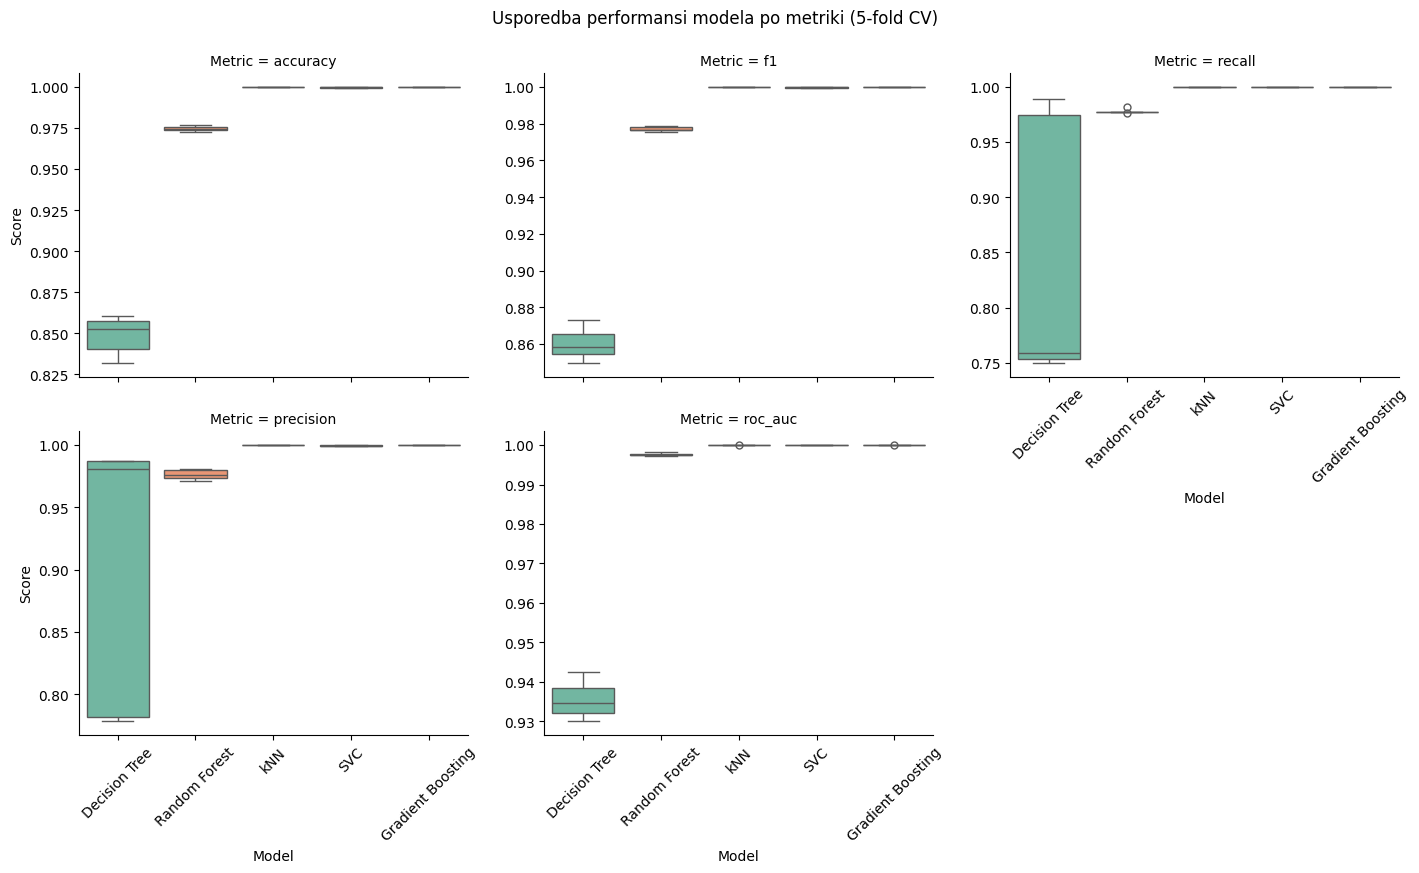

In [25]:
# 1. Catplot (boxplot) po metriki – ispravljeno prema upozorenju
g = sns.catplot(
    x='Model', y='Score', hue='Model', col='Metric', data=metrics_df,
    kind='box', col_wrap=3, height=4, aspect=1.2,
    sharey=False, palette='Set2', legend=False
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Usporedba performansi modela po metriki (5-fold CV)")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.show()


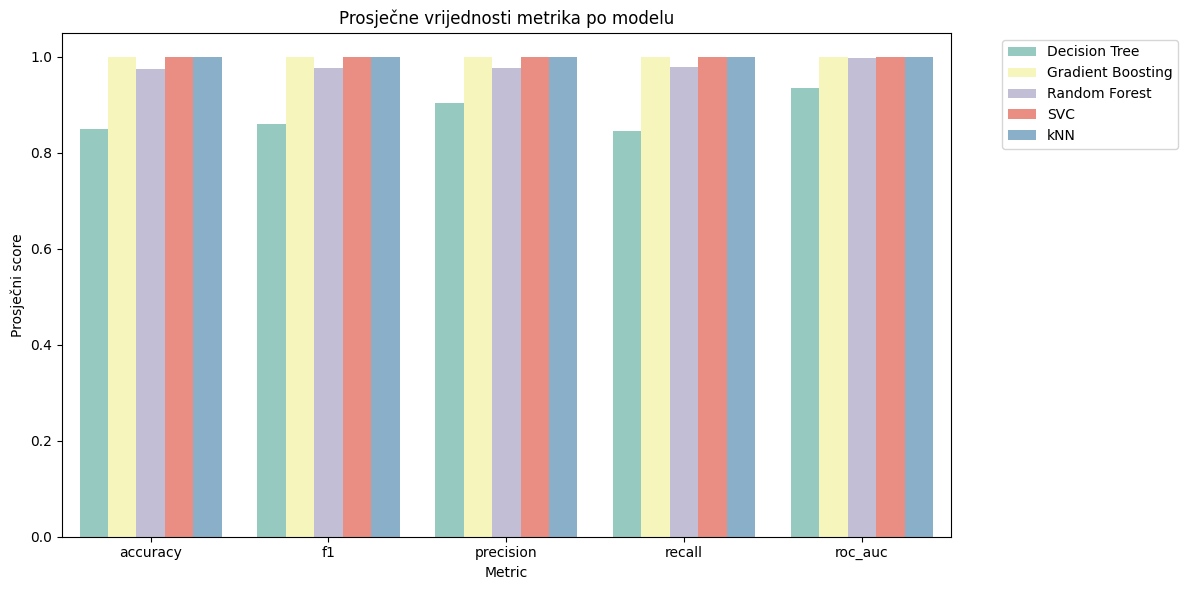

In [26]:
# 2. Barplot prosječnih rezultata
avg_scores = metrics_df.groupby(['Model', 'Metric'])['Score'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=avg_scores, palette='Set3')
plt.title("Prosječne vrijednosti metrika po modelu")
plt.ylabel("Prosječni score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

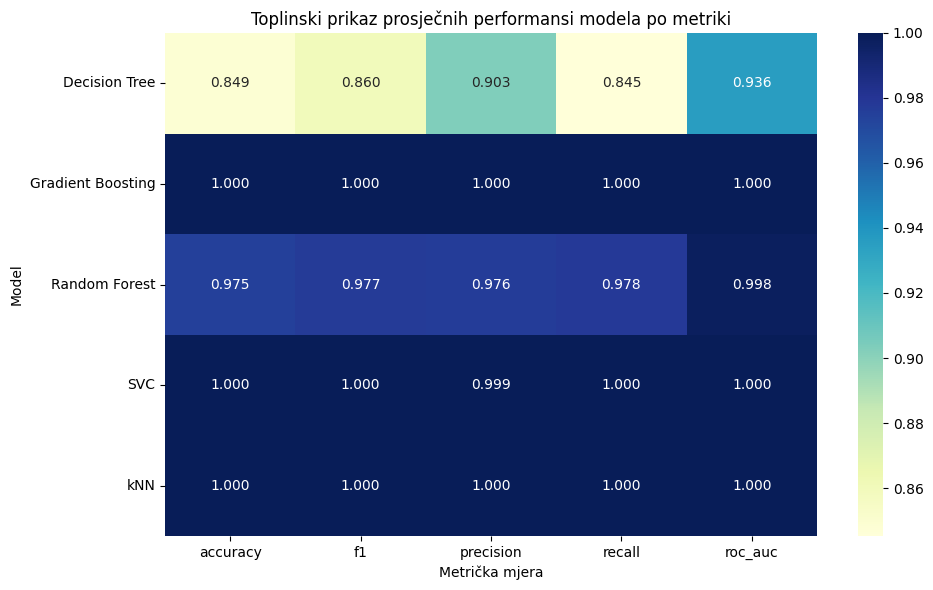

In [27]:
# 3. Heatmap: modeli vs metrike
heatmap_data = avg_scores.pivot(index='Model', columns='Metric', values='Score')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Toplinski prikaz prosječnih performansi modela po metriki")
plt.ylabel("Model")
plt.xlabel("Metrička mjera")
plt.tight_layout()
plt.show()

In [28]:
# Spremi najbolji model kao pipeline
best_model_name = max(best_scores, key=best_scores.get)
best_model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', models[best_model_name].__class__(**best_params[best_model_name]))
])
best_model_pipeline.fit(X, y)

model_file = f'mushroom_model_pipeline_{best_model_name}.pkl'
joblib.dump(best_model_pipeline, model_file)
print(f"Najbolji model spremljen kao pipeline u {model_file}")

Najbolji model spremljen kao pipeline u mushroom_model_pipeline_Gradient Boosting.pkl
